##Object Detection with DETR
Transformers are a deep learning architecture that has gained popularity in recent years, especially in NLP and speech recognition. However, computer vision has not yet been swept up by the Transformer revolution.  

To help bridge this gap, Facebook released 
Detection Transformers (DETR)
, an important new approach to object detection and panoptic segmentation. DETR completely changes the architecture compared with previous object detection systems. It is the first object detection framework to successfully integrate Transformers as a central building block in the detection pipeline. (https://ai.facebook.com/blog/end-to-end-object-detection-with-transformers/)   

In this notebook, I try to deploy the end-to-end model in the simplest fashion.

In [0]:
import torch as th
import requests
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont

In [2]:
# load the model from torch hub and set it to evaluation mode
model = th.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True)
model.eval()
model = model.cuda()

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-2c7b67e5.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-2c7b67e5.pth


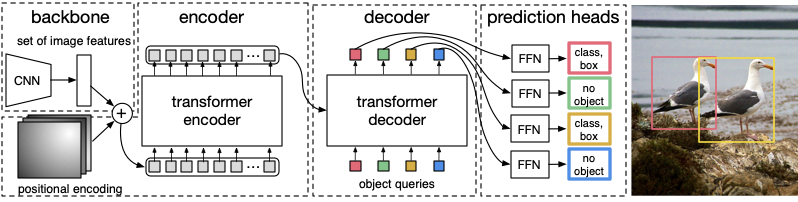

In [0]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# COCO classes
# The pre-trained DETR model that we have just loaded has been trained on the 80 COCO classes
# http://cocodataset.org/#home
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [4]:
# copy and past image address
url = input()

https://previews.123rf.com/images/marius0126/marius01261703/marius0126170300162/73897018-zebra-and-giraffe.jpg


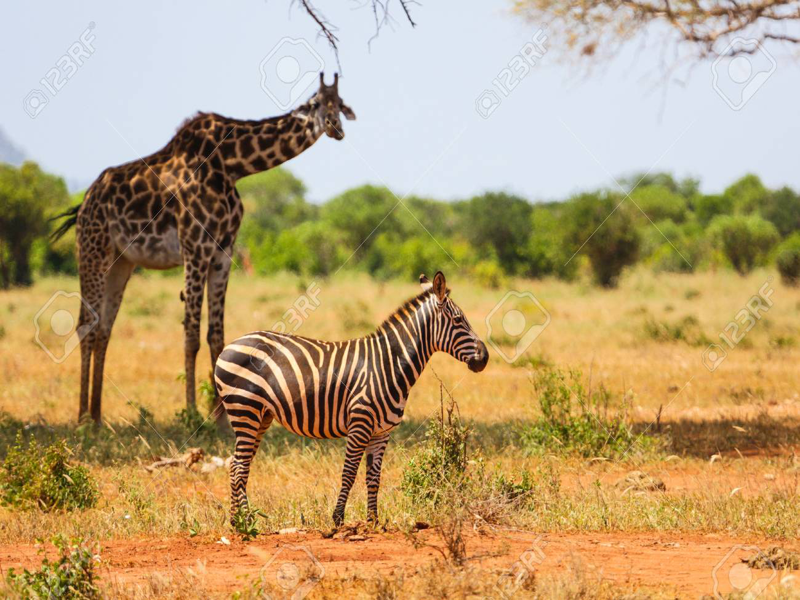

In [5]:
# get image and resize it
img = Image.open(requests.get(url, stream=True).raw).resize((800,600))
img

In [0]:
# unsqueeze returns a new tensor of size 1 at position 0
img_tens = transform(img).unsqueeze(0).cuda()

In [0]:
# run the model
with th.no_grad():
  output =  model(img_tens)

In [11]:
# we can view the model
model

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Drop

In [0]:
im2 = img.copy()
drw = ImageDraw.Draw(im2)

# logits indicate the probabilities of all classes
# a box contains x, y, w, h with x and y being the center coordinates of a box
for logits, box in zip(output['pred_logits'][0], output['pred_boxes'][0]):
  cls = logits.argmax()
  if cls >= len(CLASSES):
    continue
  label = (CLASSES[cls])
  box = box.cpu() * th.Tensor([800, 600, 800, 600])
  x, y, w, h = box
  x0, x1 = x-w//2, x+w//2
  y0, y1 = y-h//2, y+h//2
  drw.rectangle([(x0, y0), (x1, y1)], outline='lightblue', width=5)
  drw.text((x, y), label, size=10)



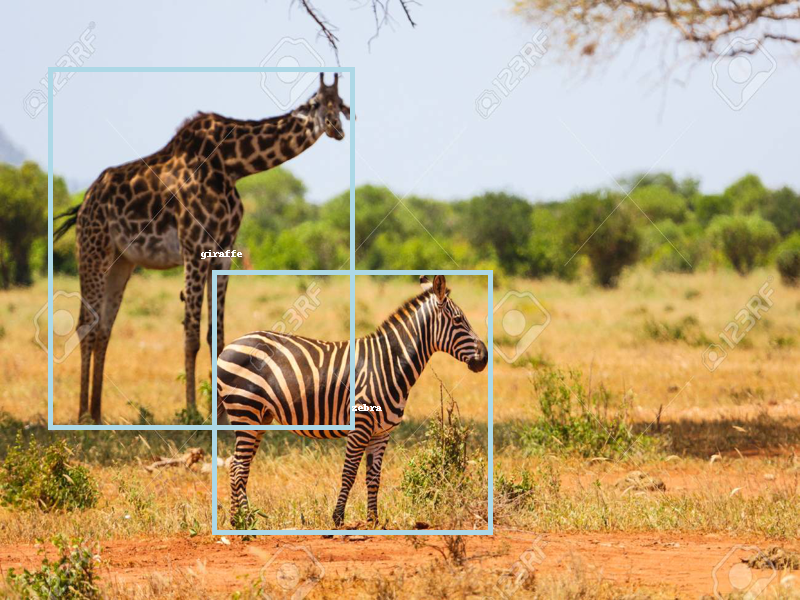

In [125]:
# visualize the output
im2